<a href="https://colab.research.google.com/github/fuat-arslan/Pytorch_Scratch/blob/main/CV/MobileNetV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MobileNetV1 Implementation**

https://arxiv.org/pdf/1704.04861.pdf

"We present a class of efficient models called MobileNets
for mobile and embedded vision applications. MobileNets
are based on a streamlined architecture that uses depthwise separable convolutions to build light weight deep
neural networks."

The MobileNet model is based on depthwise separable
convolutions which is a form of factorized convolutions
which factorize a standard convolution into a depthwise
convolution and a 1×1 convolution called a pointwise convolution.

*For MobileNets the depthwise convolution applies a single filter to each input channel. The pointwise
convolution then applies a 1×1 convolution to combine the
outputs the depthwise convolution.*

*Depthwise separable convolution are made up of two
layers: depthwise convolutions and pointwise convolutions.
We use depthwise convolutions to apply a single filter per
each input channel (input depth). Pointwise convolution, a
simple 1×1 convolution, is then used to create a linear combination of the output of the depthwise layer. MobileNets
use both batchnorm and ReLU nonlinearities for both layers.*

#Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

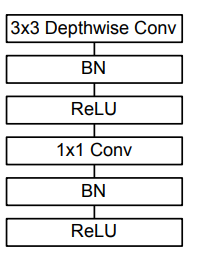

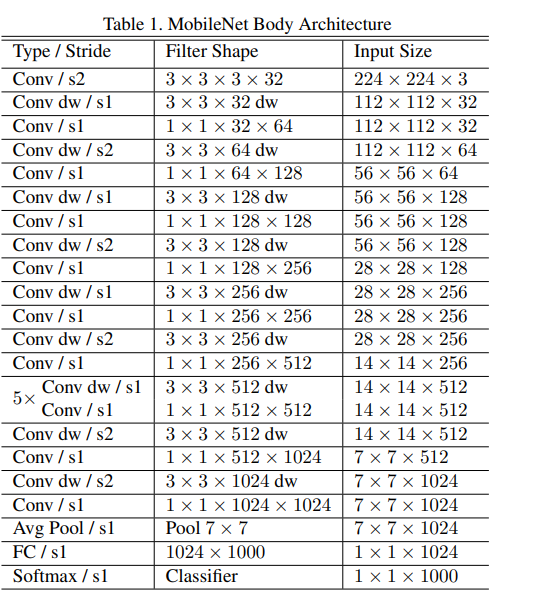

In [10]:
class Depthwise_Separable_Conv(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super().__init__()
        self.conv_depth = nn.Sequential(nn.Conv2d(input_channels, input_channels, kernel_size=3,
                                    stride = stride, padding = 1, groups=input_channels,
                                    bias=False),
                                    nn.BatchNorm2d(input_channels),
                                    nn.ReLU())
        
        self.conv_point = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=1,stride = 1, padding = 0, bias=False),
                                    nn.BatchNorm2d(output_channels),
                                    nn.ReLU())
        
    def forward(self, x):
        x = self.conv_depth(x)
        return self.conv_point(x)


In [11]:
class MobileNetV1(nn.Module):

    def __init__(self, num_classes=3):
        super().__init__()
        #RGB is assumed
        self.conv1 = nn.Sequential(nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1,bias=False),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU()
                                   )
        
        self.conv_list = [(64,1), (128,2),
                          (128,1), (256,2),
                          (256,1), (512,2),
                          (512,1), (512,1), 
                          (512,1), (512,1), 
                          (512,1), (1024,2),
                          (1024,1)]

        self.conv_block =  self.generator()
        
        self.fc = nn.Linear(1024,num_classes)


    def generator(self):
        layers = []
        input_channels = 32
        for params in self.conv_list:
            output_channels = params[0]
            stride = params[1]
            layers.append(Depthwise_Separable_Conv(input_channels,output_channels, stride))
            input_channels = output_channels
        return nn.Sequential(*layers)

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv_block(x)
        x = F.avg_pool2d(x,2)
        x = x.view(x.size(0), -1)
        return self.fc(x)
        




In [12]:
def test():
    net = MobileNetV1()
    print (net)
    x = torch.randn(1,3,32,32)
    y = net(Variable(x))
    print(y.size())

test()

MobileNetV1(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block): Sequential(
    (0): Depthwise_Separable_Conv(
      (conv_depth): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv_point): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): Depthwise_Separable_Conv(
      (conv_depth): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum

#DataLoad

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms

def train_transform():
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    return transform_train

def test_transform():
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    return transform_test

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def Dataloader(data_dir, train_batch, test_batch):
    transform_train = train_transform()
    transform_test = test_transform()

    trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch, shuffle=False, num_workers=2)

    return trainloader,testloader

In [15]:
print('==> Preparing data..')
trainloader,testloader = Dataloader("/content",32,32)


==> Preparing data..


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [17]:
print('==> Building model from scratch')
net = MobileNetV1(10)
# net.cuda()
# net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
# cudnn.benchmark = True

==> Building model from scratch


In [19]:
optimizer = optim.Adam(net.parameters(), lr=0.1, weight_decay=5e-4)

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:
use_cuda = False

In [29]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        #print(inputs.shape)
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        if batch_idx % 100 ==0:
            print("Training: Epoch: %d, batch: %d, Loss: %.3f , Acc: %.3f, Correct/Total: (%d/%d)"
                  % (epoch, batch_idx, train_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [30]:
train(1)


Epoch: 1
Training: Epoch: 1, batch: 0, Loss: 2.291 , Acc: 9.375, Correct/Total: (3/32)
Training: Epoch: 1, batch: 100, Loss: 2.287 , Acc: 13.521, Correct/Total: (437/3232)
Training: Epoch: 1, batch: 200, Loss: 2.218 , Acc: 14.879, Correct/Total: (957/6432)
Training: Epoch: 1, batch: 300, Loss: 2.180 , Acc: 15.147, Correct/Total: (1459/9632)
Training: Epoch: 1, batch: 400, Loss: 2.149 , Acc: 15.711, Correct/Total: (2016/12832)


KeyboardInterrupt: ignored

TO DO


*   Add Width Multplier
*   Add Resolution Multiplier
*   Add Softmax
*   Better Data Loader and Training function

